In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from scipy.stats import kstest
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from functools import partial
import xgboost as xgb
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklift.models import ClassTransformation
from sklift.models import TwoModels

# Получение бэйзлайна

* [0.Используемые функции](#global)
* [1.Подбор гиперапараметров с hyperopt](#hyperopt)
* [2.Solo модель](#solo)
* [3.Two models](#two)
* [4.Модель трансформации классов](#transformation)
* [5.Оценка результатов](#estimation)

In [41]:
import warnings
warnings.filterwarnings('ignore')

In [42]:
path = 'E:/retailhero-uplift/data' 

In [56]:
uplift = pd.read_csv(path + '/train.csv', encoding='utf-8', index_col='client_id', parse_dates=['first_issue_date', 'first_redeem_date'])
uplift.head()

,first_issue_date,first_redeem_date,age,gender,treatment_flg,target
client_id,,,,,,
000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U,0,1
000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F,1,1
00010925a5,2018-07-24 16:21:29,2018-09-14 16:12:49,83,U,1,1
0001f552b0,2017-06-30 19:20:38,2018-08-28 12:59:45,33,F,1,1
00020e7b18,2017-11-27 11:41:45,2018-01-10 17:50:05,73,U,1,1


In [61]:
uplift['first_issue_date'] = uplift['first_issue_date'].astype(np.int64)
uplift['first_redeem_date'] = uplift['first_redeem_date'].astype(np.int64)

In [62]:
uplift.info()

<class 'pandas.core.frame.DataFrame'>
Index: 200039 entries, 000012768d to fffff6ce77
Data columns (total 6 columns):
first_issue_date     200039 non-null int64
first_redeem_date    200039 non-null int64
age                  200039 non-null int64
gender               200039 non-null object
treatment_flg        200039 non-null int64
target               200039 non-null int64
dtypes: int64(5), object(1)
memory usage: 10.7+ MB


## <left>0.Используемые функции<a class="anchor" id="global"></a><left>

График ROC-AUC кривой.

In [16]:
def roc_auc_plot(y_test, preds):
    sns.set(font_scale=1.5)
    sns.set_color_codes("muted")

    plt.figure(figsize=(10, 8))
    fpr, tpr, thresholds_ = roc_curve(y_test, preds, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()

Mean target кодирование на кроссвалидации.

In [63]:
def mean_target_encoding(train_df, y_train, valid_df, skf):    
    glob_mean = y_train.mean()
    train_df = pd.concat([train_df, pd.Series(y_train, name='y')], axis=1)
    new_train_df = train_df.copy()
    
    cat_features = train_df.columns[train_df.dtypes == 'object'].tolist()    

    for col in cat_features:
        new_train_df[col + '_mean_target'] = [glob_mean for _ in range(new_train_df.shape[0])]

    for train_idx, valid_idx in skf.split(train_df, y_train):
        train_df_cv, valid_df_cv = train_df.iloc[train_idx, :], train_df.iloc[valid_idx, :]

        for col in cat_features:
            
            means = valid_df_cv[col].map(train_df_cv.groupby(col)['y'].mean())
            valid_df_cv[col + '_mean_target'] = means.fillna(glob_mean)
            
        new_train_df.iloc[valid_idx] = valid_df_cv
    
    new_train_df.drop(cat_features + ['y'], axis=1, inplace=True)
    
    for col in cat_features:
        means = valid_df[col].map(train_df.groupby(col)['y'].mean())
        valid_df[col + '_mean_target'] = means.fillna(glob_mean)
        
    valid_df.drop(train_df.columns[train_df.dtypes == 'object'], axis=1, inplace=True)
    
    return new_train_df, valid_df

Подсчёт значений на подборе гиперпараметров.

In [93]:
def optimize(params, cv_params, data):
    if 'max_depth' in params.keys():
        params['max_depth'] = int(params['max_depth'])
    
    cv_result = xgb.cv(params=params, dtrain=data, **cv_params)
    name = [i for i in cv_result.columns if all([i.startswith('test-'), i.endswith('-mean')])][-1]
    score = cv_result[name][-1:].values[0]
    
    return {'loss': score, 'status': STATUS_OK}

## <left>1. Подбор гиперпараметров с hyperopt<a class="anchor" id="hyperopt"></a><left>

Основные гиперпараметры, используемые в библиотеке XGBoost
* _objective_ - функция распределения
* _eta_ - размер шага
* _max_depth_ - максимальная глубина дерева
* _min_child_weight_ - минимальный вес, необходимый дочерним элементам
* _subsample_ - доля подвыборки для каждой итерации
* _colsample_bytree_ - доля колонок, участвующих в итерации
* _alpha_ - сила регуляризации L1
* _lambda_ - сила регуляризации L2
* _gamma_ - штраф на сложность деревьев
* _num_boost_round_ - число итераций (фиксируем, не следует менять вместе с _eta_)
* _early_stopping_rounds_ - число итераций для остановки, если не произошло улучшение метрики (фиксируем) 

Обработаем возраст.

In [65]:
uplift.loc[uplift['age'] > 80, 'age'] = 80
uplift.loc[uplift['age'] < 16, 'age'] = 16

Разобьём на трэйн и тест.

In [66]:
y = uplift['target']
X = uplift.drop(['target', 'treatment_flg'], axis=1)
X_train, x_valid, Y_train, y_valid = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=1)

Оценим распределение на разбиении.

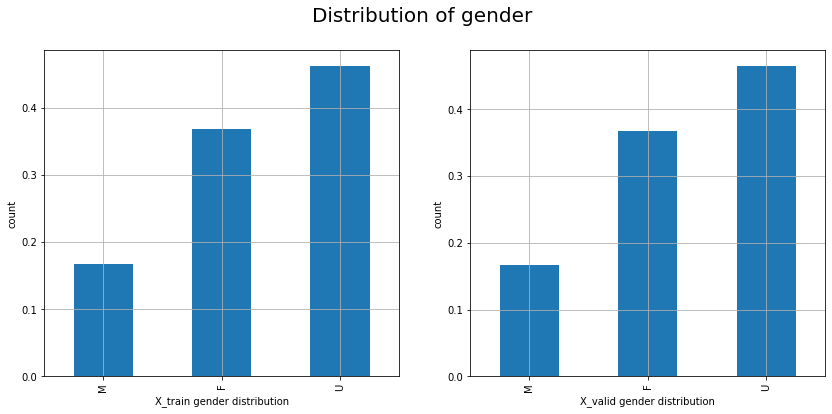

In [21]:
plt.figure(figsize = (14, 6))

plt.subplot(121)
X_train['gender'].value_counts(ascending=True, normalize=True).plot(kind='bar', grid=True)
plt.ylabel('count')
plt.xlabel(f'X_train gender distribution')

plt.subplot(122)
x_valid['gender'].value_counts(ascending=True, normalize=True).plot(kind='bar', grid=True)
plt.ylabel('count')
plt.xlabel(f'X_valid gender distribution')

plt.suptitle(f'Distribution of gender', size=20);

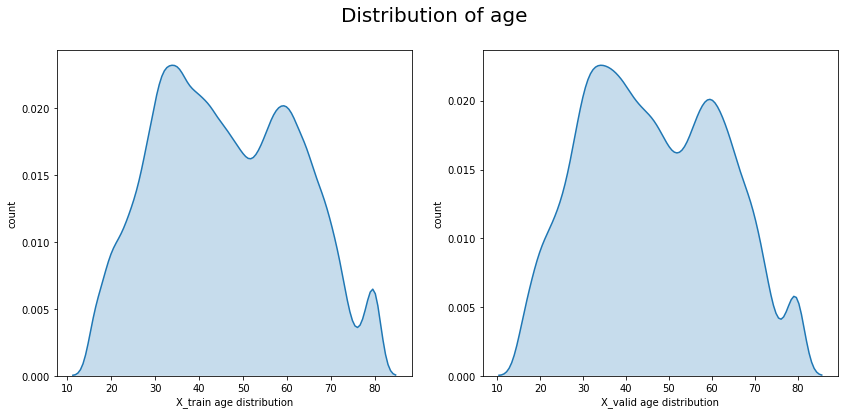

In [22]:
plt.figure(figsize = (14, 6))

plt.subplot(121)
sns.kdeplot(X_train['age'], shade=True, legend=False)
plt.ylabel('count')
plt.xlabel(f'X_train age distribution')

plt.subplot(122)
sns.kdeplot(x_valid['age'], shade=True, legend=False)
plt.ylabel('count')
plt.xlabel(f'X_valid age distribution')

plt.suptitle(f'Distribution of age', size=20);

Визуально различий в распределениях не наблюдается. Проверим тестами Колмогорова-Смирнова и Манна-Уитни на уровне значимости 0.05.

In [87]:
man, p = mannwhitneyu(x=X_train['gender'], 
                     y=x_valid['gender'])
p

0.20272672692681853

Критерий Манна-Уитни нам не позволяет принять альтернативную гипотезу о разнице распределения пола на уровне значимости 0.05.


Проверим нормальность распределения для возраста одновыборочным тестом Колмогорова-Смирнова.

In [11]:
ks_train, p_train = kstest(X_train['age'], 'norm')
ks_valid, p_valid = kstest(x_valid['age'], 'norm')
print(p_train)
print(p_valid)

0.0
0.0


Распределение не является нормальным. Проверим схожесть распределений тестом Манна-Уитни.

In [13]:
man, p = mannwhitneyu(x=X_train['age'], 
                     y=x_valid['age'])
p

0.21862048266326045

Критерий Манна-Уитни не позволяет принять альтернативную гипотезу о разнице распределения пола на уровне значимости 0.05.

Закодируем пол.

In [67]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
train_mean_target_part, valid_mean_target = mean_target_encoding(X_train, Y_train, x_valid, skf)

In [68]:
train_mean_target_part.head()

,first_issue_date,first_redeem_date,age,gender_mean_target
client_id,,,,
ef7c37ccee,1513353817000000000,1524748739000000000,61,0.640703
29c88debf2,1513345050000000000,1516542530000000000,19,0.602243
f3933afa50,1521629111000000000,1529424038000000000,65,0.642371
c79c475569,1519991186000000000,1538573923000000000,67,0.618750
60888727e2,1519995539000000000,1526069879000000000,43,0.640703


In [69]:
valid_mean_target.head()

,first_issue_date,first_redeem_date,age,gender_mean_target
client_id,,,,
2f2f21e2a3,1495999420000000000,1507130565000000000,33,0.641802
b85998d836,1502650594000000000,1505333041000000000,27,0.602901
c5c0a6ea20,1549894856000000000,1553098892000000000,63,0.641802
1fd4816e66,1552044405000000000,1556119657000000000,62,0.602901
e31773ddc3,1520792898000000000,-9223372036854775808,54,0.602901


Конвертация наборов данных в формат, поддерживающийся XGBoost.

In [82]:
train_c = xgb.DMatrix(train_mean_target_part, Y_train)
valid_c = xgb.DMatrix(valid_mean_target, y_valid)

Определим параметры кроссвалидации.

In [91]:
cv_params = {'num_boost_round': 200,
             'nfold': 5,
             'shuffle': True,
             'stratified': True,
             'maximize': False,
             'early_stopping_rounds': 20
              }

Определим пространство поиска.

In [86]:
space_freq = {'booster': hp.choice('booster', ['gbtree', 'gblinear', 'dart']),
              'objective': 'binary:logistic',
              'max_depth': hp.choice('max_depth', [5, 8, 10, 12, 15]),
              'min_child_weight': hp.uniform('min_child_weight', 0, 50),
              'subsample': hp.uniform('subsample', 0.5, 1),
              'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
              'alpha': hp.uniform('alpha', 0, 1),
              'lambda': hp.uniform('lambda', 0, 1),
              'eta': hp.uniform('eta', 0.01, 1),
              'tree_method': 'hist'
              }

Запустим поиск гиперпараметров.

In [98]:
trials = Trials()
best = fmin(fn=partial(optimize, cv_params=cv_params, data=train_c),
            space=space_freq, trials=trials, algo=tpe.suggest, max_evals=15, timeout=3600)

print(best)

100%|█████████████████████████████████████████████████████████| 15/15 [08:28<00:00, 33.87s/trial, best loss: 0.3545388]
{'alpha': 0.7671748089960383, 'booster': 0, 'colsample_bytree': 0.5512147435147441, 'eta': 0.1265523526773935, 'lambda': 0.9663740209908993, 'max_depth': 1, 'min_child_weight': 16.67544601744243, 'subsample': 0.538227954867007}


In [109]:
train_params = {'num_boost_round': 200,
                'maximize': False,
                'verbose_eval': False}

In [120]:
model = xgb.train(params={'alpha':0.7671748089960383, 
                                   'booster': 'gbtree', 
                                   'colsample_bytree': 0.5512147435147441, 
                                   'eta': 0.1265523526773935, 
                                   'lambda': 0.9663740209908993, 
                                    'max_depth': 1, 
                                    'min_child_weight': 16.67544601744243, 
                                    'subsample': 0.538227954867007}, dtrain=train_c, **train_params)

Оценим результаты.

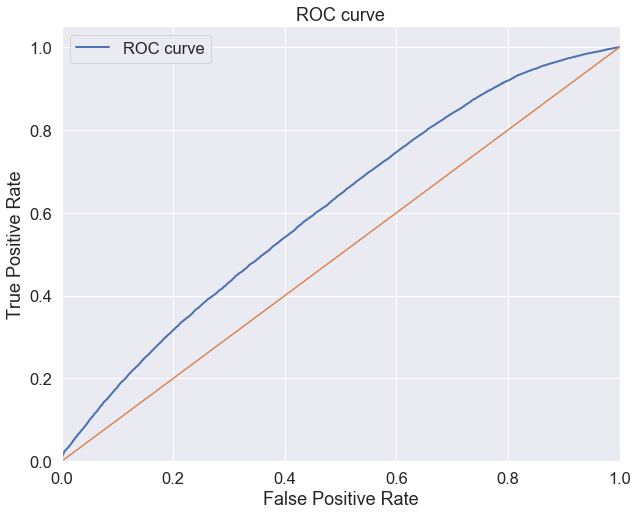

In [122]:
roc_auc_plot(y_test=y_valid, 
             preds=model.predict(valid_c))

In [123]:
roc_auc_score(y_valid, model.predict(valid_c))

0.6109851281412315

Не будем расстраиваться и займёмся фича инжинирингом. А пока выберем одну из трёх аплифт моделей.

## <left> 2. Solo модель<a class="anchor" id="solo"></a><left>

Заведём табличку для отчёта.

In [158]:
uplift_results = {
    'approach': [],
    'uplift@30%': []
}

Заведём treatment.

In [159]:
index_train, index_valid = train_test_split(uplift.index, test_size=0.3, random_state=43)
index_train.shape, index_valid.shape

((140027,), (60012,))

In [160]:
X_train = uplift.loc[index_train, :].drop(['target', 'treatment_flg'], 1)
y_train = uplift.loc[index_train, 'target']
treat_train = uplift.loc[index_train, 'treatment_flg']

X_valid = uplift.loc[index_valid, :].drop(['target', 'treatment_flg'], 1)
y_valid = uplift.loc[index_valid, 'target']
treat_valid = uplift.loc[index_valid, 'treatment_flg']

print(X_train.shape, y_train.shape, treat_train.shape)
print(X_valid.shape, y_valid.shape, treat_valid.shape)

(140027, 4) (140027,) (140027,)
(60012, 4) (60012,) (60012,)


In [161]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
train_mean_target_part, valid_mean_target = mean_target_encoding(X_train, y_train, X_valid, skf)

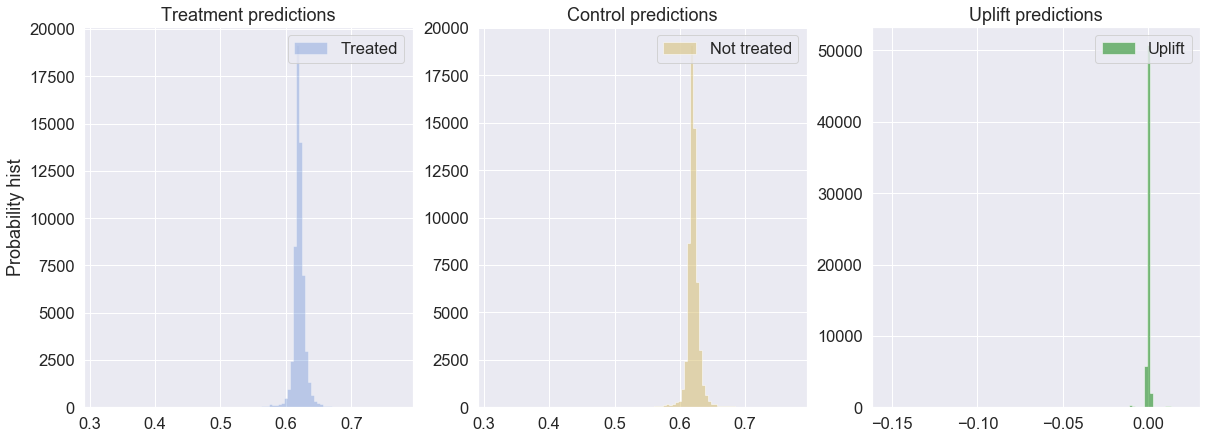

In [162]:
sm = SoloModel(xgb.XGBClassifier(params={'alpha':0.7671748089960383, 
                                   'booster': 'gbtree', 
                                   'colsample_bytree': 0.5512147435147441, 
                                   'eta': 0.1265523526773935, 
                                   'lambda': 0.9663740209908993, 
                                    'max_depth': 1, 
                                    'min_child_weight': 16.67544601744243, 
                                    'subsample': 0.538227954867007}, **train_params))
sm.fit(train_mean_target_part, Y_train, treat_train)
uplift_sm = sm.predict(valid_mean_target)
sm_score_30 = uplift_at_k(y_true=y_valid, uplift=uplift_sm, treatment=treat_valid, strategy='by_group', k=0.3)

uplift_results['approach'].append('SoloModel')
uplift_results['uplift@30%'].append(sm_score_30)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

## <left> 3. Two models<a class="anchor" id="two"></a><left>

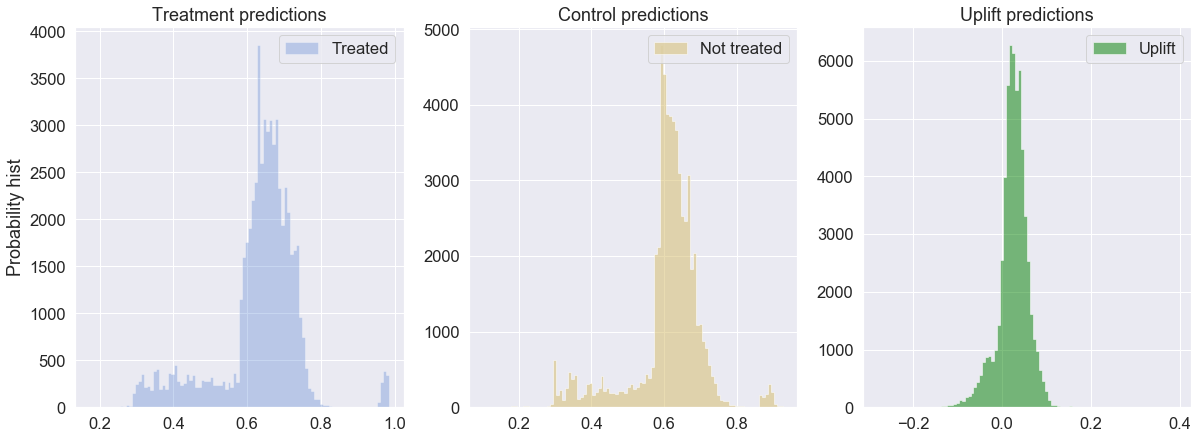

In [163]:
tm = TwoModels(
    estimator_trmnt=xgb.XGBClassifier(params={'alpha':0.7671748089960383, 
                                   'booster': 'gbtree', 
                                   'colsample_bytree': 0.5512147435147441, 
                                   'eta': 0.1265523526773935, 
                                   'lambda': 0.9663740209908993, 
                                    'max_depth': 1, 
                                    'min_child_weight': 16.67544601744243, 
                                    'subsample': 0.538227954867007}, **train_params), 
    estimator_ctrl=xgb.XGBClassifier(params={'alpha':0.7671748089960383, 
                                   'booster': 'gbtree', 
                                   'colsample_bytree': 0.5512147435147441, 
                                   'eta': 0.1265523526773935, 
                                   'lambda': 0.9663740209908993, 
                                    'max_depth': 1, 
                                    'min_child_weight': 16.67544601744243, 
                                    'subsample': 0.538227954867007}, **train_params))

tm = tm.fit(train_mean_target_part, y_train, treat_train)

uplift_tm = tm.predict(X_valid)

tm_score_30 = uplift_at_k(y_true=y_valid, uplift=uplift_tm, treatment=treat_valid, strategy='by_group', k=0.3)

uplift_results['approach'].append('TwoModels')
uplift_results['uplift@30%'].append(tm_score_30)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

## <left> 4. Модель трансформации классов<a class="anchor" id="transformation"></a><left>

In [164]:
ct = ClassTransformation(xgb.XGBClassifier(params={'alpha':0.7671748089960383, 
                                   'booster': 'gbtree', 
                                   'colsample_bytree': 0.5512147435147441, 
                                   'eta': 0.1265523526773935, 
                                   'lambda': 0.9663740209908993, 
                                    'max_depth': 1, 
                                    'min_child_weight': 16.67544601744243, 
                                    'subsample': 0.538227954867007}, **train_params))
ct = ct.fit(train_mean_target_part, y_train, treat_train)
uplift_ct = ct.predict(X_valid)

ct_score_30 = uplift_at_k(y_true=y_valid, uplift=uplift_ct, treatment=treat_valid, strategy='by_group', k=0.3)

uplift_results['approach'].append('ClassTransformation')
uplift_results['uplift@30%'].append(ct_score_30)

## <left>5. Оценка итоговых результатов<a class="anchor" id="estimate"></a><left>

In [165]:
results = pd.DataFrame(uplift_results).set_index('approach')
results

,uplift@30%
approach,
SoloModel,0.028131
TwoModels,0.073962
ClassTransformation,0.065064


Лучший результат у двух независимых моделей. Будем работать дальше с этим решением.